In [1]:
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
from torch import optim

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic=True

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
from torchvision import transforms
from torchvision.datasets import FashionMNIST

transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

path='/tmp'

# Create datasets for training & validation, download if necessary
train_set = FashionMNIST(path, train=True, transform=transform, download=True)
val_set = FashionMNIST(path, train=False, transform=transform, download=True)

# Create data loaders for our datasets; shuffle for training, not for validation
train_loader = torch.utils.data.DataLoader(train_set, batch_size=784, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=784, shuffle=False)

100%|██████████| 26421880/26421880 [00:01<00:00, 17744477.77it/s]


Extracting /tmp/FashionMNIST/raw/train-images-idx3-ubyte.gz to /tmp/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 265208.07it/s]


Extracting /tmp/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /tmp/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 4929649.89it/s]


Extracting /tmp/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /tmp/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 10615672.07it/s]

Extracting /tmp/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /tmp/FashionMNIST/raw



In [4]:
import torch.nn.functional as F

class FMNISTnet(torch.nn.Module):
  def __init__(self):
    super (FMNISTnet, self).__init__()

    self.fc1 = torch.nn.Linear(784,256)
    self.fc2 = torch.nn.Linear(256,64)
    self.fc3 = torch.nn.Linear(64,10)
   
    self.drop=torch.nn.Dropout(p=0.2)
    self.sm = torch.nn.LogSoftmax(dim=1)


  def forward(self, x):
    x=self.fc1(x)
    x=F.relu(x)
    x=self.drop(x)
    x=self.fc2(x)
    x=F.relu(x)
    x=self.drop(x)
    x=self.fc3(x)
    x = self.sm(x)
    return x


  def predict(self,x):
    with torch.no_grad():
        x=self.forward(x)
        #x=x.data.max(1)[1]
    return x


In [5]:
loss_fn = torch.nn.NLLLoss()

In [6]:
def train_model(model, optimizer, loss_fn, device, train_loader, train_losses=[],val_losses=[], EPOCHS = 10):
    print(device)
    for epoch in range(EPOCHS):
        curr_loss=0
        
        batch_size=1
        model.train(True)
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            batch_size = images.shape[0]
            # flatten the images to batch_size x 784
            #images.shape=torch.Size([784, 784])
            images = images.view(images.shape[0], -1)
            # Set mode to training - Dropouts will be used here
            optimizer.zero_grad()
            y_pred = model.forward(images)
            loss = loss_fn(y_pred, labels)
            loss.backward()
            optimizer.step()
            curr_loss+=loss.item()
            
        with torch.no_grad():
            model.eval()
            val_loss=0
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                batch_size = images.shape[0]
                # flatten the images to batch_size x 784
                #images.shape=torch.Size([784, 784])
                images = images.view(images.shape[0], -1)
                
                y_pred = model.predict(images)
                loss = loss_fn(y_pred, labels)
                
                val_loss+=loss.item()
        val_losses.append(val_loss/len(val_loader))
        train_losses.append(curr_loss/len(train_loader))
        
        
        

In [7]:
len(val_loader)
len(train_loader)

77

# Adam

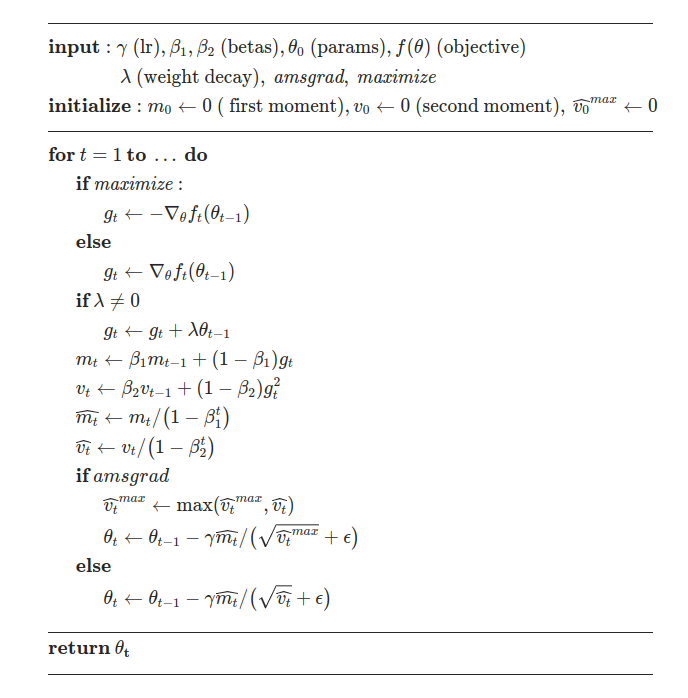

In [8]:
net_adam=FMNISTnet()
net_adam = net_adam.to(device)
opt_adam = optim.Adam(net_adam.parameters(), lr = 0.002)


In [9]:
train_losses_adam=[]
val_losses_adam=[]
train_model(model=net_adam,optimizer=opt_adam, loss_fn=loss_fn, device=device, train_loader=train_loader, train_losses=train_losses_adam,val_losses=val_losses_adam, EPOCHS = 30)

cuda


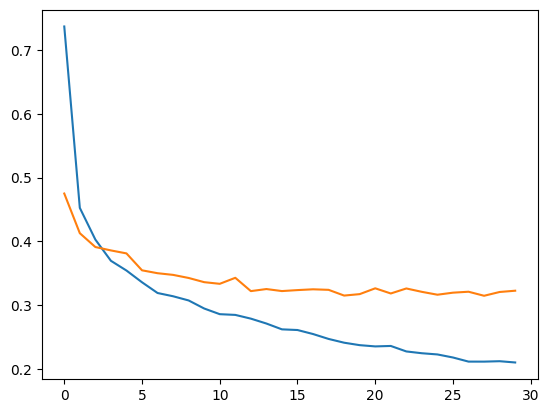

In [10]:
plt.plot(train_losses_adam, label = "Training loss")
plt.plot(val_losses_adam, label = "Val loss")

# RMSProp

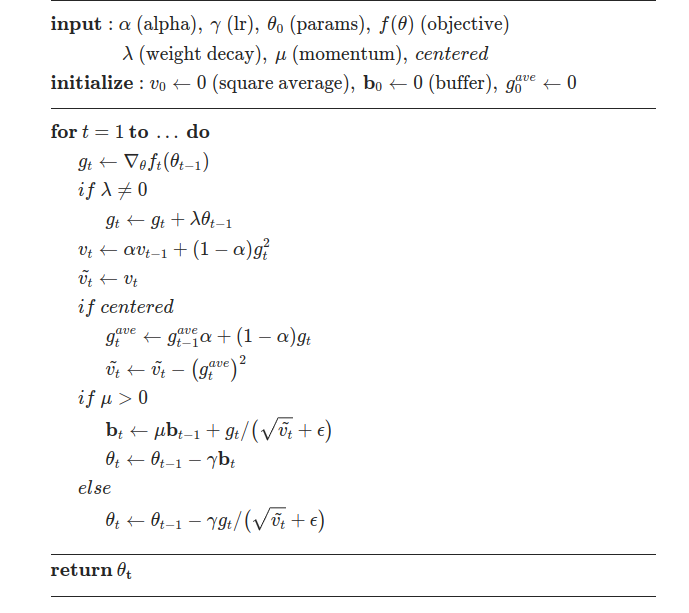

In [11]:
net_rmsprop=FMNISTnet()
net_rmsprop = net_rmsprop.to(device)
opt_rmsprop = optim.RMSprop(net_rmsprop.parameters(), lr = 0.002)


In [12]:
train_losses_rmsprop=[]
val_losses_rmsprop=[]
train_model(model=net_rmsprop,optimizer=opt_rmsprop, loss_fn=loss_fn, device=device, train_loader=train_loader, train_losses=train_losses_rmsprop,val_losses=val_losses_rmsprop, EPOCHS = 30)

cuda


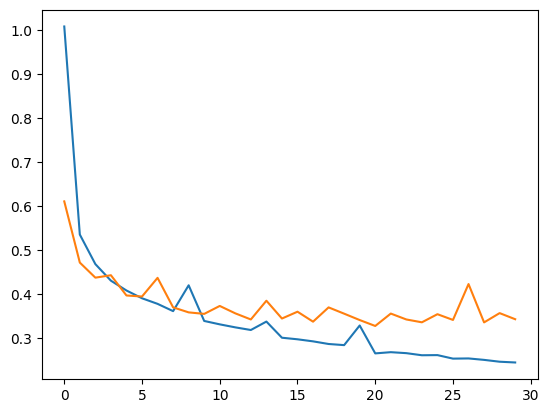

In [13]:
plt.plot(train_losses_rmsprop, label = "Training loss")
plt.plot(val_losses_rmsprop, label = "Val loss")

# AdaGrad

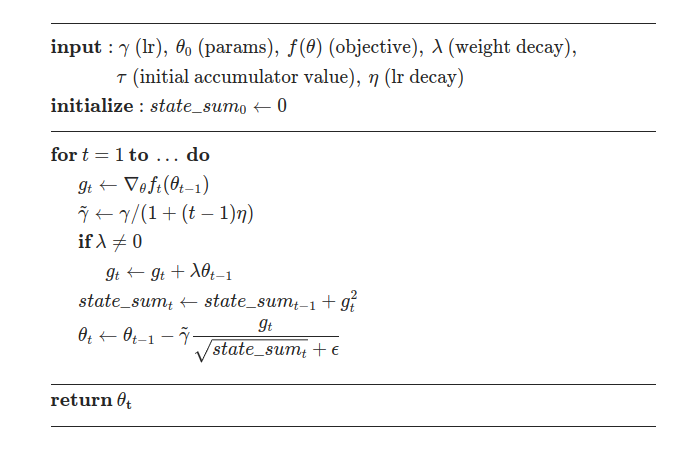

In [14]:
net_adagrad=FMNISTnet()
net_adagrad = net_adagrad.to(device)
opt_adagrad = optim.Adagrad(net_adagrad.parameters(), lr = 0.002)


In [15]:
train_losses_adagrad=[]
val_losses_adagrad=[]
train_model(model=net_adagrad,optimizer=opt_adagrad, loss_fn=loss_fn, device=device, train_loader=train_loader, train_losses=train_losses_adagrad,val_losses=val_losses_adagrad, EPOCHS = 30)

cuda


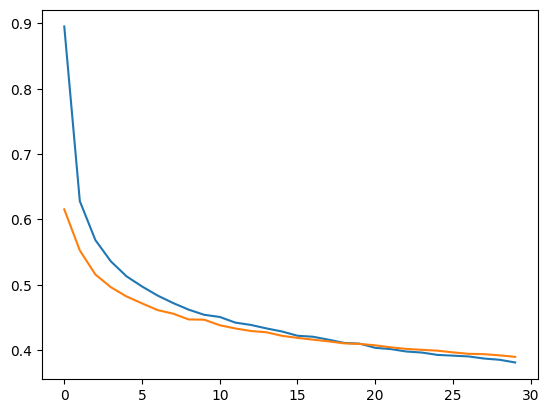

In [16]:
plt.plot(train_losses_adagrad, label = "Training loss")
plt.plot(val_losses_adagrad, label = "Val loss")

# Momentum

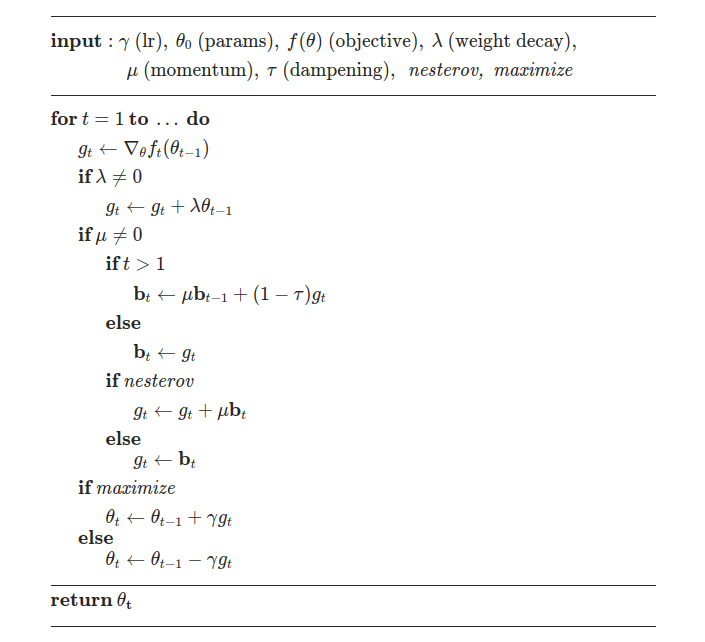

In [17]:
net_momentum=FMNISTnet()
net_momentum = net_momentum.to(device)
opt_momentum = optim.SGD(net_momentum.parameters(), lr = 0.002, momentum=0.9)

In [18]:
train_losses_momentum=[]
val_losses_momentum=[]
train_model(model=net_momentum,optimizer=opt_momentum, loss_fn=loss_fn, device=device, train_loader=train_loader, train_losses=train_losses_momentum,val_losses=val_losses_momentum, EPOCHS = 30)

cuda


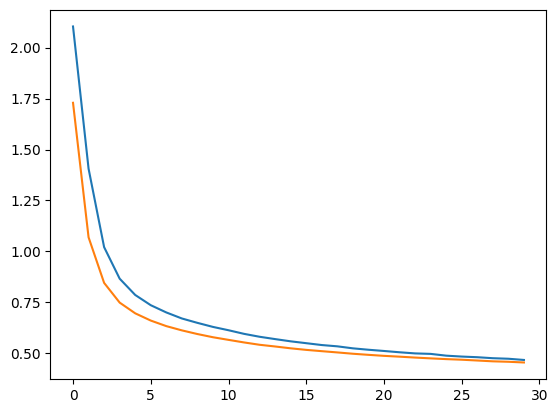

In [19]:
plt.plot(train_losses_momentum, label = "Training loss")
plt.plot(val_losses_momentum, label = "Val loss")

# SGD

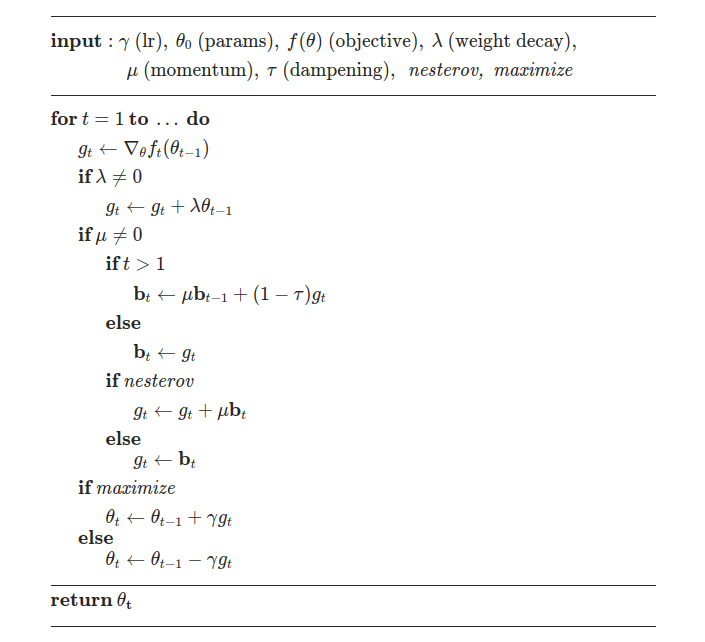

In [20]:
net_sgd=FMNISTnet()
net_sgd = net_sgd.to(device)
opt_sgd = optim.SGD(net_sgd.parameters(), lr = 0.002)

In [21]:
train_losses_sgd=[]
val_losses_sgd=[]
train_model(model=net_sgd,optimizer=opt_sgd, loss_fn=loss_fn, device=device, train_loader=train_loader, train_losses=train_losses_sgd,val_losses=val_losses_sgd, EPOCHS = 30)

cuda


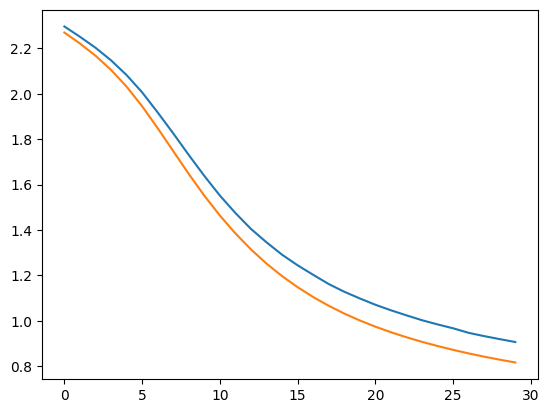

In [22]:
plt.plot(train_losses_sgd, label = "Training loss")
plt.plot(val_losses_sgd, label = "Val loss")

# AdaMax

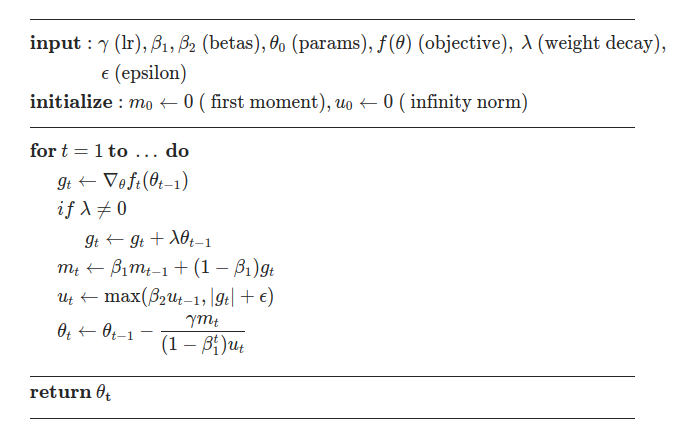

In [23]:
net_adamax=FMNISTnet()
net_adamax = net_adamax.to(device)
opt_adamax = optim.Adamax(net_adamax.parameters(), lr = 0.002)

In [24]:
train_losses_adamax=[]
val_losses_adamax=[]
train_model(model=net_adamax,optimizer=opt_adamax, loss_fn=loss_fn, device=device, train_loader=train_loader, train_losses=train_losses_adamax,val_losses=val_losses_adamax, EPOCHS = 30)

cuda


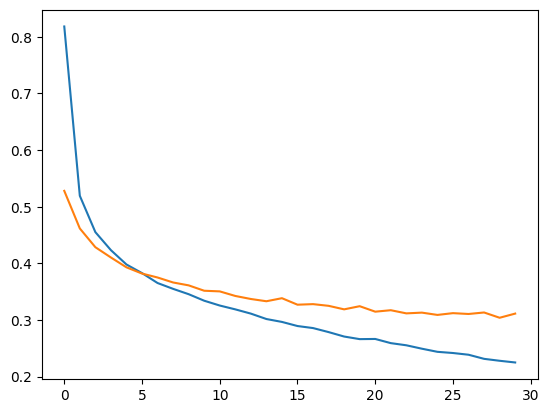

In [25]:
plt.plot(train_losses_adamax, label = "Training loss")
plt.plot(val_losses_adamax, label = "Val loss")

# Общий график

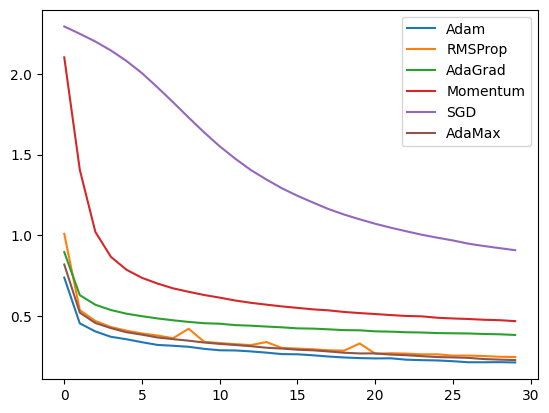

In [26]:
plt.plot(train_losses_adam, label = "Adam")
plt.plot(train_losses_rmsprop, label = "RMSProp")
plt.plot(train_losses_adagrad, label = "AdaGrad")
plt.plot(train_losses_momentum, label = "Momentum")
plt.plot(train_losses_sgd, label = "SGD")
plt.plot(train_losses_adamax, label = "AdaMax")
plt.legend()